# Vertical Coord Transforms

I need to figure out how to take a ds_gridded with dimensions `density`, `lon`, `lat` and transform it to have dimensions `av isopycnal depth`, `lon`, `lat`. I've done this before for data with dimensions `density`, `N_PROF`. I don't think this will be very difficult?? Hoping I just have to 
1. flatten the dataset into having dimensions `density`, `N_PROF`
2. perform calculations with established functions
3. reshape the dataset back into the original dimensions of `density`, `lon`, `lat`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

Text(0.5, 1.0, 'CT')

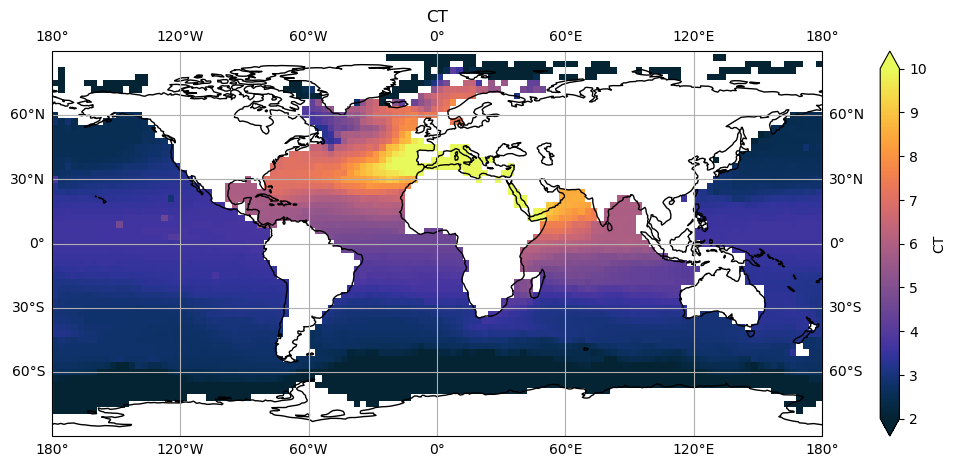

In [465]:
ds = ds_gridded_rho.CT
title= 'CT'
cmap, norm = cmo.thermal, colors.Normalize(vmin=2, vmax=10)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=27.5, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f'{title}')

In [13]:
K_e_3dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/K_e_CT.nc')
ds_gridded_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_rho.nc')
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_x.nc')

Text(0.5, 1.0, 'Depth, density=27.5m')

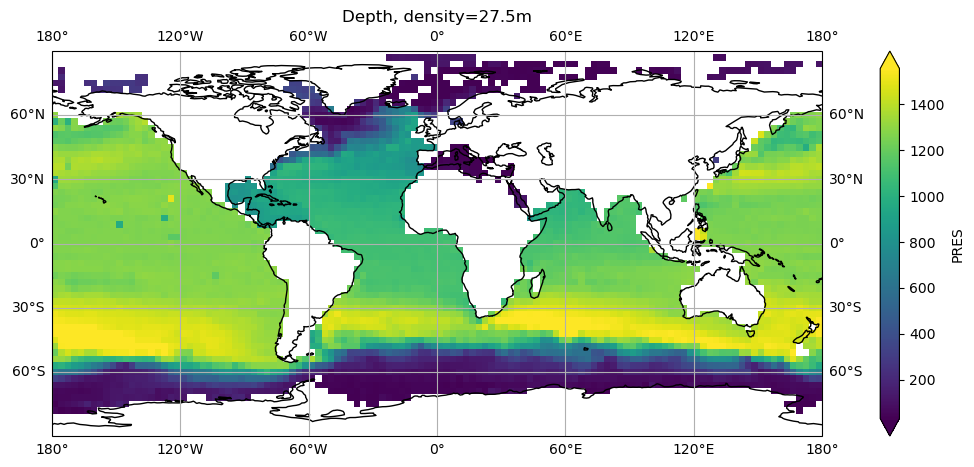

In [14]:
density = 27.5
ds = ds_gridded_rho.PRES

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), robust=True)
plt.title(f'Depth, density={density}m')

# New Attempt

In [381]:
from itertools import product
import time
import xarray as xr
import numpy as np
from scipy import interpolate
from tqdm import tqdm

In [390]:
def prepare_monotonic_interpolation_coords(P: xr.DataArray) -> xr.DataArray:
    """
    Takes a pressure profile and returns a strictly increasing,
    NaN-free interpolation coordinate. Handles edge cases gracefully.
    """
    P_vals = np.asarray(P.squeeze().values)
    P_vals_clean = P_vals[~np.isnan(P_vals)]

    # Guard against empty array after dropping NaNs
    if P_vals_clean.size == 0:
        return xr.DataArray([], dims='density', coords={'density': []})

    # Enforce monotonicity
    sorted_idx = np.argsort(P_vals_clean)
    P_sorted = P_vals_clean[sorted_idx]

    dx = np.diff(P_sorted)
    keep_mask = dx > 0

    # Handle case where diff returns empty array
    if P_sorted.size == 0:
        P_final = P_sorted
    else:
        valid_idx = np.concatenate(([True], keep_mask))
        if valid_idx.shape[0] != P_sorted.shape[0]:
            # Fall back to keeping all points if mask size doesn't match
            valid_idx = np.ones_like(P_sorted, dtype=bool)
        P_final = P_sorted[valid_idx]

    return xr.DataArray(P_final, dims='density', coords={'density': np.arange(len(P_final))})

def func_var_int_pmean(ds_nonan, Pmean_nonan, Pmax, variable, dim1='N_PROF'): 
    Pmean_grid = np.linspace(0, 2000, 1001)
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values, extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan * Pmean_grid
    ds_pmean = xr.DataArray(
        ds_on_Pmean.reshape((-1, 1)),
        dims=['Pmean', dim1],
        coords={'Pmean': Pmean_grid, dim1: [0]}  # dummy profile index
    ).rename(variable)
    return ds_pmean

ERROR! Session/line number was not unique in database. History logging moved to new session 1076


In [ ]:
def pmean_lon_lat(ds_in, variable='SPICE', Pmean_source='PRES', Pmax=2000):
    Pmean_grid = np.linspace(0, 2000, 1001)
    lon_vals = ds_in.lon.values
    lat_vals = ds_in.lat.values

    result_array = np.full((len(Pmean_grid), len(lon_vals), len(lat_vals)), np.nan)

    index_pairs = list(product(range(len(lon_vals)), range(len(lat_vals))))
    start_time = time.time()

    for count, (i, j) in enumerate(tqdm(index_pairs, desc=f'Interpolating {variable} profiles')):
        profile_var = ds_in[variable].isel(lon=i, lat=j)
        profile_P = ds_in[Pmean_source].isel(lon=i, lat=j)

        var_nonan = profile_var.dropna(dim='density')
        Pmean_nonan = profile_P.dropna(dim='density')
        Pmean_sorted = prepare_monotonic_interpolation_coords(Pmean_nonan)

        if len(var_nonan) != len(Pmean_sorted):
            minlen = min(len(var_nonan), len(Pmean_sorted))
            var_nonan = var_nonan.isel(density=slice(0, minlen))
            Pmean_sorted = Pmean_sorted.isel(density=slice(0, minlen))

        interpolated = func_var_int_pmean(
            var_nonan, Pmean_sorted, Pmax, variable
        ).squeeze()

        result_array[:, i, j] = interpolated.values
        
    return xr.DataArray(
        result_array,
        dims=['Pmean', 'lon', 'lat'],
        coords={'Pmean': Pmean_grid, 'lon': lon_vals, 'lat': lat_vals},
        name=variable
    )

In [394]:
CT_Pmean = pmean_lon_lat(ds_gridded_rho, variable='CT')

Interpolating CT profiles: 100%|██████████| 7080/7080 [00:19<00:00, 369.82it/s]


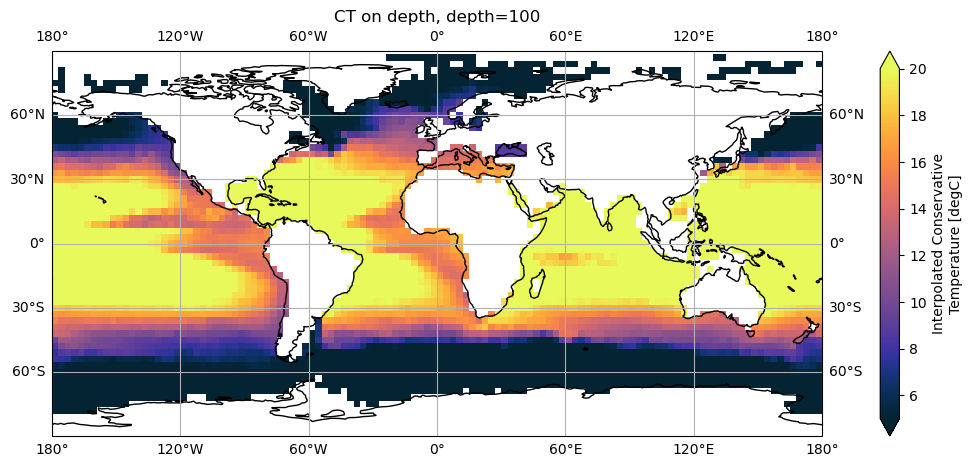

In [405]:
depth = 100
ds = ds_gridded.CT
title= 'CT on depth'
cmap, norm = cmo.thermal, colors.Normalize(vmin=5, vmax=20)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(PRES_INTERPOLATED=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, depth={ds.PRES_INTERPOLATED.sel(PRES_INTERPOLATED=depth, method='nearest').PRES_INTERPOLATED.values}");

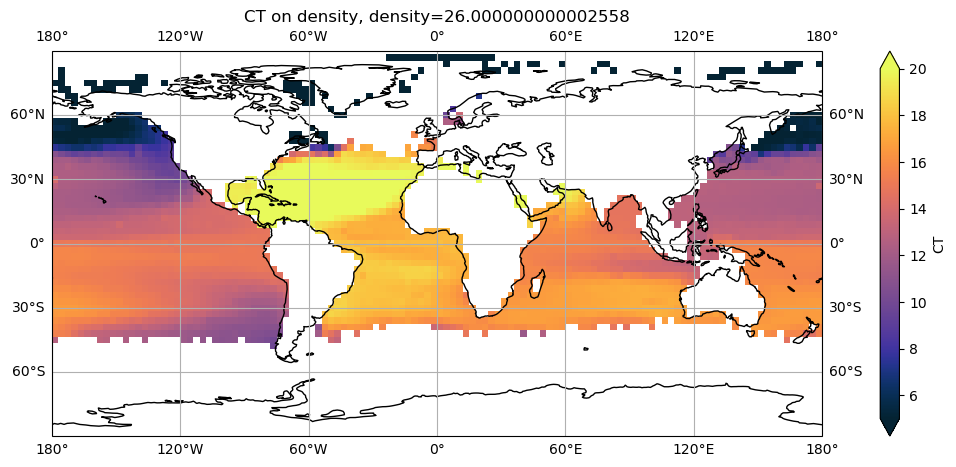

In [448]:
density = 26
ds = ds_gridded_rho.CT
title= 'CT on density'
cmap, norm = cmo.thermal, colors.Normalize(vmin=5, vmax=20)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density={ds.density.sel(density=density, method='nearest').density.values}");

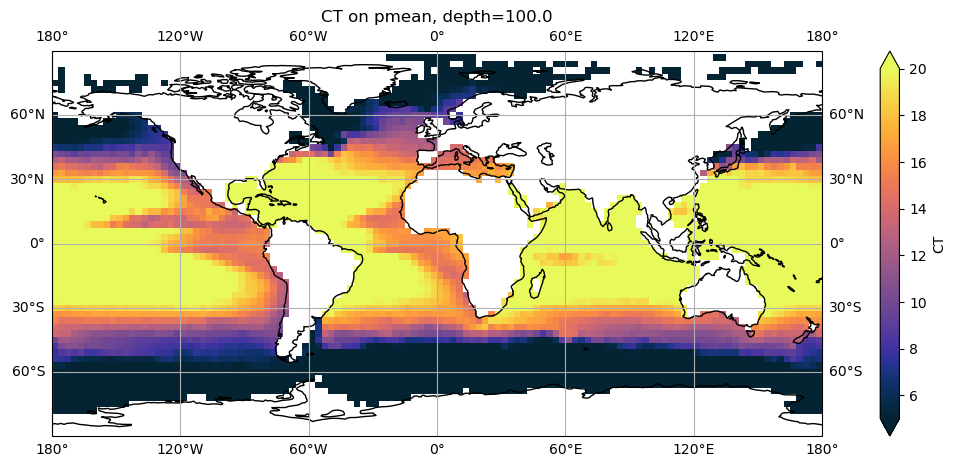

In [404]:
depth = 100
ds = CT_Pmean
title= 'CT on pmean'
cmap, norm = cmo.thermal, colors.Normalize(vmin=5, vmax=20)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(Pmean=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, depth={ds.Pmean.sel(Pmean=depth, method='nearest').Pmean.values}");

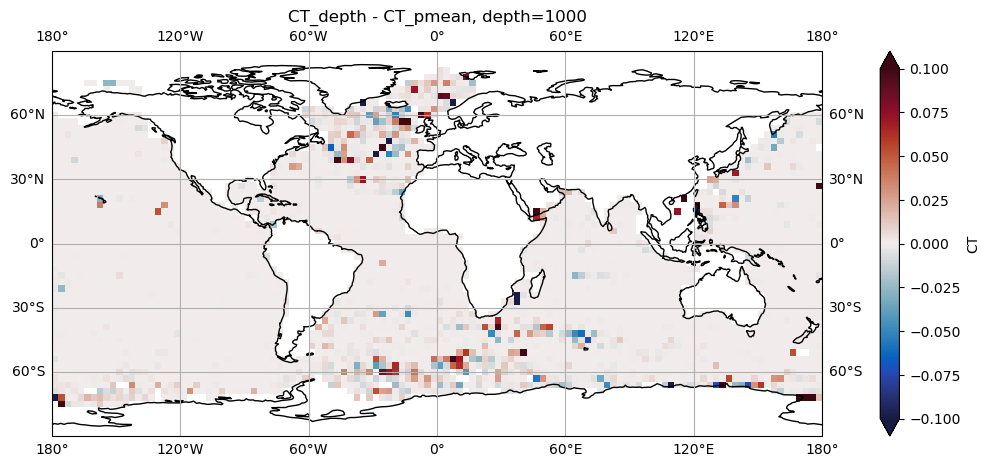

In [466]:
depth = 1000
ds = (ds_gridded.CT.rename({'PRES_INTERPOLATED':'depth'}) - CT_Pmean.rename({'Pmean':'depth'}))
title= 'CT_depth - CT_pmean'
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.1, vmax=0.1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(depth=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, depth={ds.depth.sel(depth=depth, method='nearest').depth.values}");

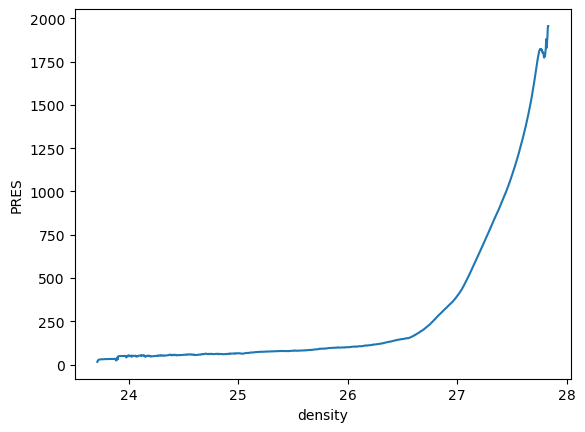

In [500]:
section_rho.PRES.mean('N_PROF').dropna(dim='density').plot()

(1600.0, 1900.0)

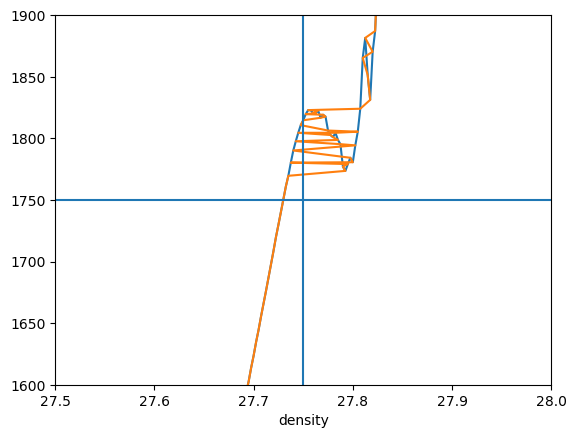

In [518]:
section_rho.PRES.mean('N_PROF').dropna(dim='density').plot()
prepare_monotonic_interpolation_coords(section_rho.PRES.mean('N_PROF').dropna(dim='density')).plot()
plt.axhline(1750)
plt.axvline(27.75)
plt.xlim(27.5,28)
plt.ylim(1600,1900)

In [516]:
import numpy as np

np.set_printoptions(threshold=np.inf)  # disables truncation
prepare_monotonic_interpolation_coords(section_rho.PRES.mean('N_PROF').dropna(dim='density'))

<xarray.DataArray (density: 1647)> Size: 7kB
array([  15.155311,   20.978106,   21.622475,   23.879879,   24.92362 ,
         25.147745,   26.544611,   27.488497,   28.07603 ,   28.356926,
         28.499817,   28.86802 ,   29.184032,   29.451262,   29.673103,
         29.852959,   29.994226,   30.113174,   30.226618,   30.334787,
         30.437878,   30.536085,   30.629604,   30.718634,   30.790583,
         30.803366,   30.883999,   30.96073 ,   31.03375 ,   31.10326 ,
         31.169455,   31.222527,   31.23253 ,   31.29268 ,   31.350103,
         31.404993,   31.457548,   31.507961,   31.55643 ,   31.603153,
         31.648321,   31.692133,   31.734785,   31.776472,   31.81739 ,
         31.857735,   31.897703,   31.93749 ,   31.977293,   32.01717 ,
         32.05617 ,   32.0941  ,   32.130985,   32.16686 ,   32.201748,
         32.235683,   32.268696,   32.30081 ,   32.332066,   32.362488,
         32.392105,   32.420948,   32.449043,   32.47643 ,   32.503128,
         32.52917 ,   32.554592,   32.57942 ,   32.603676,   32.627403,
         32.650623,   32.673367,   32.695667,   32.71258 ,   36.77649 ,
         41.35051 ,   41.85981 ,   41.989887,   42.357334,   45.900135,
         46.002934,   46.20858 ,   46.526966,   46.563877,   46.5851  ,
         46.77064 ,   46.771202,   46.881317,   47.030533,   47.161808,
         47.179703,   47.244507,   47.248844,   47.264824,   47.30501 ,
         47.306183,   47.43697 ,   47.50347 ,   47.572254,   47.595985,
...
       1288.765   , 1295.266   , 1301.4946  , 1307.4467  , 1313.7498  ,
       1319.9364  , 1326.1189  , 1332.2844  , 1339.0117  , 1345.208   ,
       1352.0746  , 1358.625   , 1365.4937  , 1371.8843  , 1378.706   ,
       1385.5197  , 1392.2969  , 1399.12    , 1406.2203  , 1413.4933  ,
       1420.3832  , 1427.736   , 1435.2909  , 1442.9401  , 1450.652   ,
       1458.9583  , 1466.5435  , 1474.0978  , 1482.0269  , 1489.9689  ,
       1497.7375  , 1505.5059  , 1513.6968  , 1521.9388  , 1530.1003  ,
       1539.2917  , 1547.4135  , 1556.1108  , 1564.919   , 1573.6366  ,
       1583.5226  , 1593.8185  , 1602.667   , 1613.7639  , 1623.5989  ,
       1634.6719  , 1644.536   , 1655.5693  , 1665.6798  , 1676.2327  ,
       1686.8936  , 1697.4248  , 1708.431   , 1719.7933  , 1729.8566  ,
       1740.3834  , 1750.4917  , 1760.9552  , 1769.5807  , 1773.5558  ,
       1777.0669  , 1779.102   , 1780.2695  , 1780.6018  , 1784.2134  ,
       1790.1235  , 1794.29    , 1795.2556  , 1797.6167  , 1798.7046  ,
       1800.9539  , 1802.6793  , 1804.4912  , 1804.4955  , 1805.3661  ,
       1806.3224  , 1810.7001  , 1814.6382  , 1816.6877  , 1817.5884  ,
       1819.1534  , 1819.5985  , 1820.3978  , 1820.4204  , 1822.5597  ,
       1822.8771  , 1822.9036  , 1824.0139  , 1831.2113  , 1851.348   ,
       1865.2507  , 1870.2887  , 1881.506   , 1887.1224  , 1933.0273  ,
       1956.1136  , 1956.5465  ], dtype=float32)
Coordinates:
  * density  (density) float64 13kB 23.71 23.72 23.72 ... 27.83 27.83 27.83

In [486]:
def prepare_monotonic_interpolation_coords(P: xr.DataArray) -> xr.DataArray:
    """
    Takes a 1D pressure profile and returns a strictly increasing,
    NaN-free interpolation coordinate. Preserves original density coordinate values.
    """
    # Squeeze and drop NaNs
    P_clean = P.squeeze().dropna(dim='density')

    if P_clean.size == 0:
        return xr.DataArray(
            [], dims='density', coords={'density': []}
        )

    # Sort pressure values (and carry density coords)
    sorted_idx = np.argsort(P_clean.values)
    P_sorted = P_clean.isel(density=sorted_idx)
    density_sorted = P_sorted['density']

    # Keep strictly increasing steps
    dx = np.diff(P_sorted.values)
    keep_mask = dx > 0
    valid_idx = np.concatenate(([True], keep_mask))

    P_final = P_sorted.isel(density=valid_idx)
    density_final = density_sorted.values[valid_idx]

    return xr.DataArray(
        P_final.values,
        dims='density',
        coords={'density': density_final}
    )

In [519]:
def pmean_N_PROF(ds_in, variable='SPICE', Pmean_source='PRES', Pmax=2000):
    Pmean_grid = np.linspace(0, Pmax, 1001)
    N = ds_in.sizes['N_PROF']

    result_array = np.full((len(Pmean_grid), N), np.nan)
    start_time = time.time()
    profile_P = ds_in[Pmean_source].mean('N_PROF')

    for i in tqdm(range(N), desc=f'Interpolating {variable} profiles'):
        profile_var = ds_in[variable].isel(N_PROF=i)

        var_nonan = profile_var.dropna(dim='density')
        Pmean_nonan = profile_P.dropna(dim='density')
        Pmean_sorted = prepare_monotonic_interpolation_coords(Pmean_nonan)

        if len(var_nonan) != len(Pmean_sorted):
            minlen = min(len(var_nonan), len(Pmean_sorted))
            var_nonan = var_nonan.isel(density=slice(0, minlen))
            Pmean_sorted = Pmean_sorted.isel(density=slice(0, minlen))

        interpolated = func_var_int_pmean(
            var_nonan, Pmean_sorted, Pmax, variable
        ).squeeze()

        result_array[:, i] = interpolated.values

        #if i % 500 == 0 and i > 0:
        #    elapsed = time.time() - start_time
        #    per_profile = elapsed / (i + 1)
        #    remaining = per_profile * (N - i - 1)
        #    print(f"⏱️ Time/profile: {per_profile:.2f}s | Est. remaining: {remaining:.1f}s")

    return var_nonan, Pmean_sorted, xr.DataArray(
        result_array,
        dims=['Pmean', 'N_PROF'],
        coords={
            'Pmean': Pmean_grid,
            'N_PROF': ds_in.N_PROF,
            'LATITUDE': ('N_PROF', ds_in['LATITUDE'].values),
            'LONGITUDE': ('N_PROF', ds_in['LONGITUDE'].values),
        },
        name=variable
    )

In [479]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_high_res.nc')
ds_x   = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [493]:
section_rho = ds_rho.where((ds_rho.LATITUDE < -40) & (ds_rho.LATITUDE > -50),drop=True).where((ds_rho.LONGITUDE < 30) & (ds_rho.LONGITUDE > 20),drop=True).sortby('LATITUDE')
section_x = ds_x.where((ds_x.LATITUDE < -40) & (ds_x.LATITUDE > -50),drop=True).where((ds_x.LONGITUDE < 30) & (ds_x.LONGITUDE > 20),drop=True).sortby('LATITUDE')

In [494]:
section_rho = section_rho.rename({'rho_grid':'density'})

In [521]:
var_nonan, Pmean_sorted, section_pmean = pmean_N_PROF(section_rho, variable='CT')

Interpolating CT profiles: 100%|██████████| 4027/4027 [00:14<00:00, 287.39it/s]


In [522]:
var_nonan

<xarray.DataArray 'CT' (density: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * density    (density) float64 0B 
    N_PROF     int64 8B 829635
    LATITUDE   float64 8B -40.0
    LONGITUDE  float64 8B 21.18

In [523]:
Pmean_sorted

<xarray.DataArray (density: 0)> Size: 0B
array([], dtype=float32)
Coordinates:
  * density  (density) float64 0B

In [524]:
section_pmean

<xarray.DataArray 'CT' (Pmean: 1001, N_PROF: 4027)> Size: 32MB
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
...
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan]])
Coordinates:
  * Pmean      (Pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * N_PROF     (N_PROF) int64 32kB 784326 211295 211001 ... 239482 830523 829635
    LATITUDE   (N_PROF) float64 32kB -50.0 -49.99 -49.99 ... -40.0 -40.0 -40.0
    LONGITUDE  (N_PROF) float64 32kB 25.33 23.68 22.06 ... 28.69 23.12 21.18

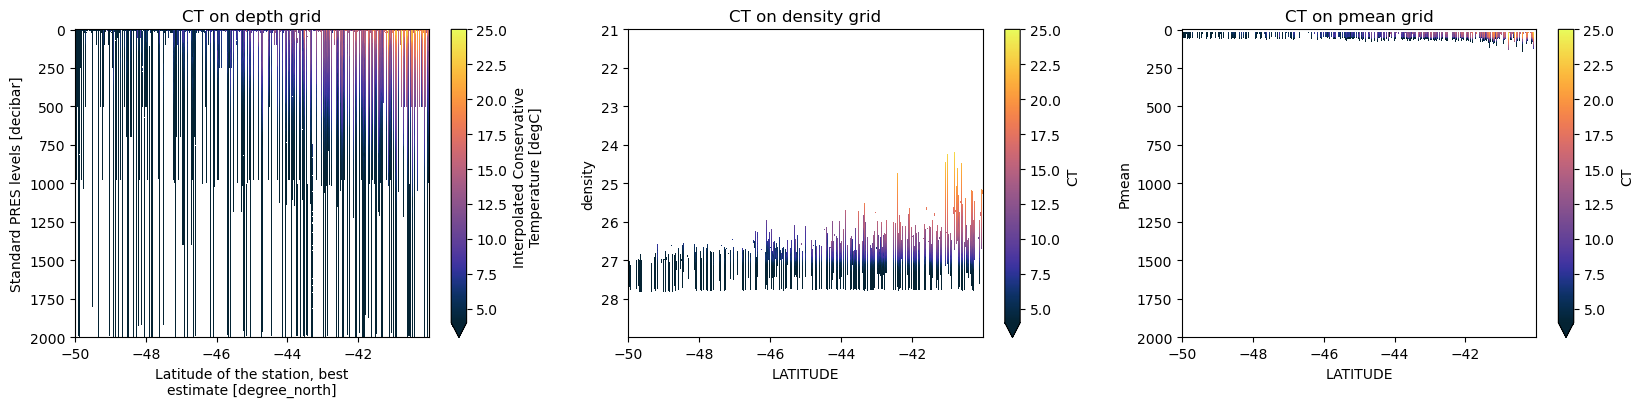

In [525]:
plt.figure(figsize=(20,4))

plt.subplot(131)
section_x.CT.plot(x='LATITUDE', y='PRES_INTERPOLATED', cmap=cmo.thermal, vmin=4, vmax=25)
plt.gca().invert_yaxis()
plt.title('CT on depth grid')

plt.subplot(132)
section_rho.CT.plot(x='LATITUDE', y='density', cmap=cmo.thermal, vmin=4, vmax=25)
plt.gca().invert_yaxis()
plt.title('CT on density grid')

plt.subplot(133)
section_pmean.plot(x='LATITUDE', y='Pmean', cmap=cmo.thermal, vmin=4, vmax=25)
plt.gca().invert_yaxis()
plt.title('CT on pmean grid')

plt.subplots_adjust(wspace=0.25)

Text(0.5, 1.0, 'section_x - section_pmean')

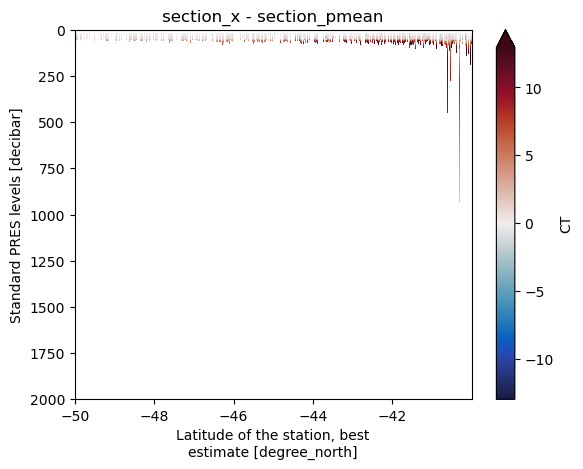

In [497]:
(section_x.CT.rename({'PRES_INTERPOLATED':'depth'})-section_pmean.rename({'Pmean':'depth'})).plot(x='LATITUDE',y='depth', cmap=cmo.balance, robust=True)
plt.gca().invert_yaxis()
plt.title('section_x - section_pmean')

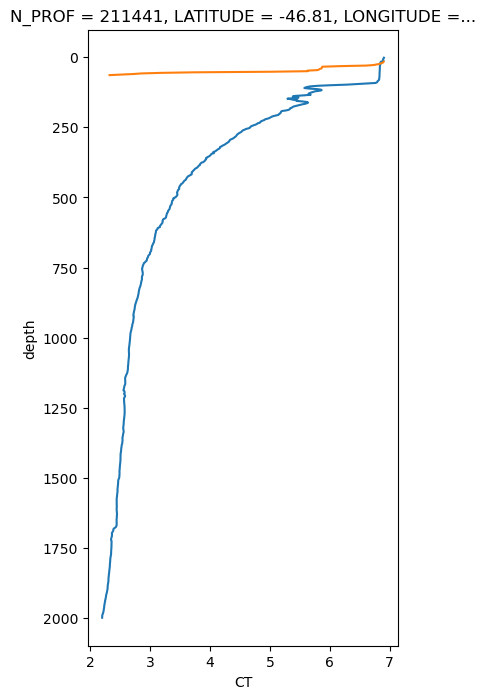

In [498]:
prof = 1000
plt.figure(figsize=(4,8))
section_x.CT.isel(N_PROF=prof).rename({'PRES_INTERPOLATED':'depth'}).plot(y='depth')
section_pmean.isel(N_PROF=prof).rename({'Pmean':'depth'}).plot(y='depth')
plt.gca().invert_yaxis()